# The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import * 
from fastai import *

The data block API leps you customize how to create a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
- where are the inputs
- how to label them
- how to split the data into a training and validation set
- what type of [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) to create
- possible transforms to apply
- how to warp in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)

This is a bit longer than using the factory methods but is way more flexible. As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

In [`vision.data`](/vision.data.html#vision.data), we create an easy [`DataBunch`](/basic_data.html#DataBunch) suitable for classification by simply typing:

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

This is aimed at data that is in fodlers following an ImageNet style, with a train and valid directory containing each one subdirectory per class, where all the pictures are. With the data block API, the same thing is achieved like this:

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
tfms = get_transforms(do_flip=False)

In [ ]:
data = (ImageFileList.from_folder(path)        #Where to find the data? -> in path and its subfolders
        .label_from_folder()                   #How to label? -> depending on the folder of the filenames
        .split_by_folder()                     #How to split in train/valid? -> use the folders
        .datasets(ImageClassificationDataset)  #How to convert to datasets? -> use ImageClassificationDataset
        .img_transform(tfms, size=224)         #Data augmetnation? -> use tfms with a size of 224
        .img_databunch())                      #Finally? -> use the defaults for conversion to ImageDataBunch

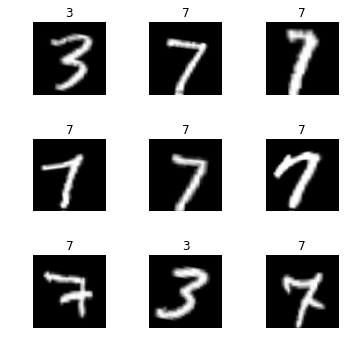

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [ ]:
planet = untar_data(URLs.PLANET_SAMPLE)
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', sep = ' ',
    ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

With the data block API we can rewrite this like that:

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (ImageFileList.from_folder(planet)            
        #Where to find the data? -> in planet and its subfolders
        .label_from_csv('labels.csv', sep=' ', folder='train', suffix='.jpg')  
        #How to label? -> use the csv file labels.csv in path, adds .jpg to the names and take them in the folder train
        .random_split_by_pct()                     
        #How to split in train/valid? -> randomly with the defulat 20% in valid
        .datasets(ImageMultiDataset)  
        #How to convert to datasets? -> use ImageMultiDataset
        .img_transform(tfms, size=128)             
        #Data augmetnation? -> use tfms with a size of 128
        .img_databunch())                          
        #Finally? -> use the defaults for conversion to databunch

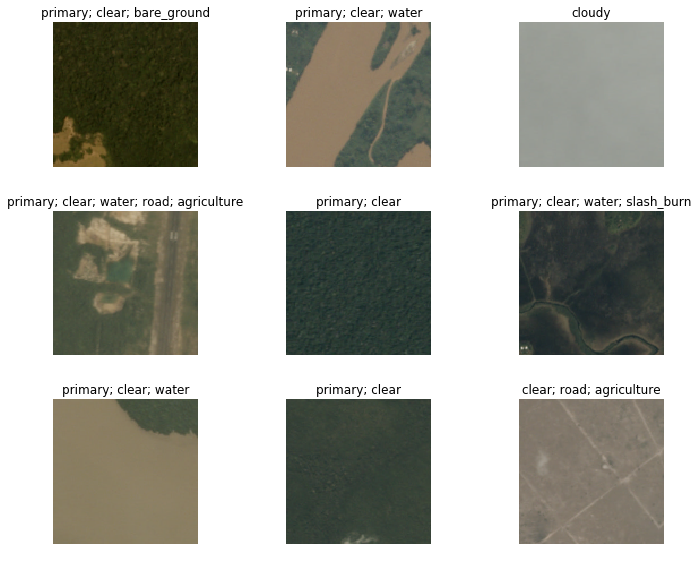

In [ ]:
data.show_batch(rows=3, figsize=(10,8))

## Give the inputs

The inputs we want to feed our model are regrouped in the following class. It contains methods to then attribute labels to them.

In [ ]:
show_doc(InputList, title_level=3, doc_string=False)

<h3 id="InputList"><code>class</code> <code>InputList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L38" class="source_link">[source]</a></h3>

> <code>InputList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`) :: [`PathItemList`](/data_block.html#PathItemList)

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...)

In [ ]:
show_doc(InputList.from_folder)

<h4 id="InputList.from_folder"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L40" class="source_link">[source]</a></h4>

> <code>from_folder</code>(`path`:`PathOrStr`=`'.'`, `extensions`:`StrList`=`None`, `recurse`=`True`) → `InputList`

Get the list of files in `path` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

Note that [`InputList`](/data_block.html#InputList) is subclassed in vision by [`ImageFileList`](/vision.data.html#ImageFileList) that changes the default of `extensions` to image file extensions (which is why we used [`ImageFileList`](/vision.data.html#ImageFileList) in our previous examples).

## Labelling the inputs

All the followings are methods of [`InputList`](/data_block.html#InputList). Note that some of them are primarly intended for inputs that are filenames and might not work in general situations.

In [ ]:
show_doc(InputList.label_from_csv)

<h4 id="InputList.label_from_csv"><code>label_from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L71" class="source_link">[source]</a></h4>

> <code>label_from_csv</code>(`csv_fname`, `header`:`Union`\[`int`, `str`, `NoneType`\]=`'infer'`, `fn_col`:`int`=`0`, `label_col`:`int`=`1`, `sep`:`str`=`None`, `folder`:`PathOrStr`=`'.'`, `suffix`:`str`=`None`) → `LabelList`

Look in `self.path/csv_fname` for a csv loaded with an optional `header` containing the filenames in `fn_col` to get the corresponding label in `label_col`.
If a `folder` is specified, filenames are taken in `path/folder`. `suffix` is added.
If `sep` is specified, splits the values in `label_col` accordingly.
This method is intended for inputs that are filenames. 

In [ ]:
jekyll_note("This method will only keep the filenames that are both present in the csv file and in `self.items`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method will only keep the filenames that are both present in the csv file and in `self.items`.</div>

In [ ]:
show_doc(InputList.label_from_df)

<h4 id="InputList.label_from_df"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L60" class="source_link">[source]</a></h4>

> <code>label_from_df</code>(`df`, `fn_col`:`int`=`0`, `label_col`:`int`=`1`, `sep`:`str`=`None`, `folder`:`PathOrStr`=`'.'`, `suffix`:`str`=`None`) → `LabelList`

Look in `df` for the filenames in `fn_col` to get the corresponding label in `label_col`. If a `folder` is specified, filenames are taken in `self.path/folder`. `suffix` is added.
If `sep` is specified, splits the values in `label_col` accordingly.
This method is intended for inputs that are filenames. 

In [ ]:
jekyll_note("This method will only keep the filenames that are both present in the dataframe and in `self.items`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method will only keep the filenames that are both present in the dataframe and in `self.items`.</div>

In [ ]:
show_doc(InputList.label_from_folder)

<h4 id="InputList.label_from_folder"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L81" class="source_link">[source]</a></h4>

> <code>label_from_folder</code>(`classes`:`StrList`=`None`) → `LabelList`

Give a label to each filename depending on its folder. If `classes` are specified, only keep those. This method is intended for inputs that are filenames. 

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

In [ ]:
show_doc(InputList.label_from_func)

<h4 id="InputList.label_from_func"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L45" class="source_link">[source]</a></h4>

> <code>label_from_func</code>(`func`:`Callable`) → `LabelList`

Apply `func` to every input to get its label.  

In [ ]:
show_doc(InputList.label_from_re)

<h4 id="InputList.label_from_re"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L49" class="source_link">[source]</a></h4>

> <code>label_from_re</code>(`pat`:`str`, `full_path`:`bool`=`False`) → `LabelList`

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name. This method is primarly intended for inputs that are filenames, but could work in other settings. 

In [ ]:
show_doc(LabelList, title_level=3, doc_string=False)

<h3 id="LabelList"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L88" class="source_link">[source]</a></h3>

> <code>LabelList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`) :: [`PathItemList`](/data_block.html#PathItemList)

A list of labelled inputs in `items` (expected to be tuples of input, label) with a `path` attribute. This class contains methods to create `SplitDataset`. In future development, it will contain factory methods to directly create a [`LabelList`](/data_block.html#LabelList) from a source of labelled data (a csv file or a dataframe with inputs and labels) for instance.

## Split the data between train and validation.

The following functions are methods of [`LabelList`](/data_block.html#LabelList), to create a [`SplitData`](/data_block.html#SplitData) in different ways.

In [ ]:
show_doc(LabelList.random_split_by_pct)

<h4 id="LabelList.random_split_by_pct"><code>random_split_by_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L123" class="source_link">[source]</a></h4>

> <code>random_split_by_pct</code>(`valid_pct`:`float`=`0.2`) → `SplitData`

Split the items randomly by putting `valid_pct` in the validation set.  

In [ ]:
show_doc(LabelList.split_by_files)

<h4 id="LabelList.split_by_files"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L93" class="source_link">[source]</a></h4>

> <code>split_by_files</code>(`valid_names`:[`InputList`](/data_block.html#InputList)) → `SplitData`

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(LabelList.split_by_fname_file)

<h4 id="LabelList.split_by_fname_file"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L99" class="source_link">[source]</a></h4>

> <code>split_by_fname_file</code>(`fname`:`PathOrStr`, `path`:`PathOrStr`=`None`) → `SplitData`

Split the data by using the file names in `fname` for the validation set. `path` will override `self.path`. This method won't work if you inputs aren't filenames. 

In [ ]:
show_doc(LabelList.split_by_folder)

<h4 id="LabelList.split_by_folder"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L113" class="source_link">[source]</a></h4>

> <code>split_by_folder</code>(`train`:`str`=`'train'`, `valid`:`str`=`'valid'`) → `SplitData`

Split the data depending on the folder (`train` or `valid`) in which the filenames are. This method won't work if you inputs aren't filenames. 

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

In [ ]:
show_doc(LabelList.split_by_idx)

<h4 id="LabelList.split_by_idx"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L107" class="source_link">[source]</a></h4>

> <code>split_by_idx</code>(`valid_idx`:`Collection`\[`int`\]) → `SplitData`

Split the data according to the indexes in `valid_idx`.  

In [ ]:
show_doc(SplitData, title_level=3)

<h3 id="SplitData"><code>class</code> <code>SplitData</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L130" class="source_link">[source]</a></h3>

> <code>SplitData</code>(`path`:`PathOrStr`, `train`:[`LabelList`](/data_block.html#LabelList), `valid`:[`LabelList`](/data_block.html#LabelList))

Regroups `train` and `valid` data, inside a `path`.  

## Create datasets

To create the datasets from [`SplitData`](/data_block.html#SplitData) we have the following class method.

In [ ]:
show_doc(SplitData.datasets)

<h4 id="SplitData.datasets"><code>datasets</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L141" class="source_link">[source]</a></h4>

> <code>datasets</code>(`dataset_cls`:`type`, `kwargs`) → `SplitDatasets`

Create datasets from the underlying data using `dataset_cls` and passing the `kwargs`.  

In [ ]:
show_doc(SplitDatasets, title_level=3)

<h3 id="SplitDatasets"><code>class</code> <code>SplitDatasets</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L151" class="source_link">[source]</a></h3>

> <code>SplitDatasets</code>(`path`:`PathOrStr`, `train_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `valid_ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), `test_ds`:`Optional`\[[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)\]=`None`)

A class regrouping `train_ds`, a `valid_ds` and maybe a `train_ds` dataset, inside a `path`.  

This class can be constructed directly from one of the following factory methods.

In [ ]:
show_doc(SplitDatasets.from_single)

<h4 id="SplitDatasets.from_single"><code>from_single</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L167" class="source_link">[source]</a></h4>

> <code>from_single</code>(`path`:`PathOrStr`, `ds`:[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) → `SplitDatasets`

Factory method that uses `ds` for both valid and train, and passes `path`.  

In [ ]:
show_doc(SplitDatasets.single_from_c)

<h4 id="SplitDatasets.single_from_c"><code>single_from_c</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L177" class="source_link">[source]</a></h4>

> <code>single_from_c</code>(`path`:`PathOrStr`, `c`:`int`) → `SplitDatasets`

Factory method that passes a [`SingleClassificationDataset`](/basic_data.html#SingleClassificationDataset) on `c` to `from_single`.  

In [ ]:
show_doc(SplitDatasets.single_from_classes)

<h4 id="SplitDatasets.single_from_classes"><code>single_from_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L172" class="source_link">[source]</a></h4>

> <code>single_from_classes</code>(`path`:`PathOrStr`, `classes`:`StrList`) → `SplitDatasets`

Factory method that passes a [`SingleClassificationDataset`](/basic_data.html#SingleClassificationDataset) on `classes` to `from_single`.  

Then we can build the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) around our [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) like this.

In [ ]:
show_doc(SplitDatasets.dataloaders)

<h4 id="SplitDatasets.dataloaders"><code>dataloaders</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L163" class="source_link">[source]</a></h4>

> <code>dataloaders</code>(`kwargs`) → `Collection`\[[`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)\]

Create dataloaders with the inner datasets, pasing the `kwargs`.  

The methods `img_transform` and `img_databunch` used earlier are documented in [`vision.data`](/vision.data.html#vision.data).

## Utility classes

In [ ]:
show_doc(ItemList, title_level=3)

<h3 id="ItemList"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L12" class="source_link">[source]</a></h3>

> <code>ItemList</code>(`items`:`Iterator`)

A collection of items with `__len__` and `__getitem__` with `ndarray` indexing semantics.  

In [ ]:
show_doc(PathItemList, title_level=3)

<h3 id="PathItemList"><code>class</code> <code>PathItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L19" class="source_link">[source]</a></h3>

> <code>PathItemList</code>(`items`:`Iterator`, `path`:`PathOrStr`=`'.'`) :: [`ItemList`](/data_block.html#ItemList)

An [`ItemList`](/data_block.html#ItemList) with a `path` attribute.  